In [1]:
%%capture
!cp /kaggle/input/rcnnutils/engine.py .
!cp /kaggle/input/rcnnutils/utils.py .
!cp /kaggle/input/rcnnutils/coco_eval.py .
!cp /kaggle/input/rcnnutils/coco_utils.py .
!cp /kaggle/input/rcnnutils/transforms.py .
!mkdir -p /root/.cache/torch/checkpoints
!cp /kaggle/input/resnet50/resnet50-19c8e357.pth /root/.cache/torch/checkpoints/
!cp /kaggle/input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl .
!pip install pycocotools-2.0-cp37-cp37m-linux_x86_64.whl

In [2]:
import os
import ast
import numpy as np
import pandas as pd
from collections import namedtuple

import gc
import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations.bbox_utils import denormalize_bbox, normalize_bbox

import matplotlib.pyplot as plt

import utils
from engine import train_one_epoch, evaluate

In [3]:
DATA_DIR = '/kaggle/input/global-wheat-detection'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
DETECTION_THRESHOLD = 0.40

In [4]:
def get_train_df():
    train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

    # Let's expand the bounding box coordinates and calculate the area of all the bboxes
    train_df[['x_min','y_min', 'width', 'height']] = pd.DataFrame([ast.literal_eval(x) for x in train_df.bbox.tolist()], index= train_df.index)
    train_df = train_df[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
    train_df = train_df.drop(['bbox', 'source'], axis=1)
    return train_df
train_df = get_train_df()

In [5]:
# train_df = train_df.iloc[:2000]

In [6]:
sample_sub_df = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
sample_sub_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [7]:
def get_model(pre_trained=True):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pre_trained)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (wheat heads) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [8]:
%%capture
model = get_model(pre_trained=False)
model.to(DEVICE)
model.load_state_dict(torch.load(f'/kaggle/input/fasterrcnn-training-on-augmented-data-pytorch/fasterrcnn_augmented_10.pth', map_location=DEVICE))

# Setting model in evaluation mode for getting pseudo labels
model.eval()

In [9]:
class WheatDatasetTest(Dataset):
    
    def __init__(self, image_ids):
        self.image_ids = image_ids
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index][:-4]
        image = cv2.imread(os.path.join(DATA_DIR, 'test', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        # Convert from NHWC to NCHW as pytorch expects images in NCHW format
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image)

        return image_id, image

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))


def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

## Predict on unseen test dataset and get the labels

In [11]:
def get_pseudo_labels(test_data_loader):
    model.eval()
    model.to(DEVICE)
    pseudo_labels = []

    for image_ids, images in test_data_loader:

        images = list(image.to(DEVICE) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            boxes = boxes[scores >= DETECTION_THRESHOLD].astype(np.int32)
            scores = scores[scores >= DETECTION_THRESHOLD]
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            for box in boxes:
                pseudo_labels.append({
                'image_id': image_id,
                'x_min': box[0],
                'y_min': box[1],
                'width': box[2],
                'height': box[3]
            })
    pseudo_train_df = pd.DataFrame(pseudo_labels)
    return pseudo_train_df

In [12]:
test_dataset = WheatDatasetTest(os.listdir(os.path.join(DATA_DIR, 'test')))

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [13]:
pseudo_train_df = get_pseudo_labels(test_data_loader)

## We got pseudo labels! Now let's retrain the same model with all the training data as well as all the pseudo labels

In [14]:
def get_train_augs():
    return albumentations.Compose([
        albumentations.Flip(p=0.60),
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.60),
        albumentations.HueSaturationValue(p=0.60),
        ToTensorV2()
    ], bbox_params = {
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def get_valid_augs():
    return albumentations.Compose([
        ToTensorV2()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [15]:
class WheatDatasetTrain(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.image_ids = train_df['image_id'].unique()
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        
        path = os.path.join(DATA_DIR, 'train', f'{image_id}.jpg')
        if not os.path.isfile(os.path.join(DATA_DIR, 'train', f'{image_id}.jpg')):
            path = os.path.join(DATA_DIR, 'test', f'{image_id}.jpg')

        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # Get bbox coordinates for each wheat head(s)
        bboxes_df = self.df[self.df['image_id'] == image_id]
        boxes, areas = [], []
        n_objects = len(bboxes_df)  # Number of wheat heads in the given image

        for i in range(n_objects):
            x_min = bboxes_df.iloc[i]['x_min']
            x_max = x_min + bboxes_df.iloc[i]['width']
            y_min = bboxes_df.iloc[i]['y_min']
            y_max = y_min + bboxes_df.iloc[i]['height']
            boxes.append([x_min, y_min, x_max, y_max])
            areas.append(bboxes_df.iloc[i]['area'])
            
        
        # Convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Get the labels. We have only one class (wheat head)
        labels = torch.ones((n_objects, ), dtype=torch.int64)
        
        areas = torch.as_tensor(areas)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((n_objects, ), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([index]),
            'area': areas,
            'iscrowd': iscrowd
        }
        
        if self.transforms:
            aug_result = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = aug_result['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*aug_result['bboxes'])))).permute(1, 0)

        return image, target

In [16]:
def train(train_df):
    model.train()
    model.to(DEVICE)

    # our dataset has two classes only - background and wheat heads
    num_classes = 2

    # use our dataset and defined transformations
    dataset = WheatDatasetTrain(train_df, get_train_augs())
    dataset_test = WheatDatasetTrain(train_df, get_valid_augs())

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=16, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=16, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01,
                                momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    num_epochs = 4

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, DEVICE, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=DEVICE)

## Pseudo Labeling Round #1

In [17]:
if len(os.listdir(os.path.join(DATA_DIR, 'test'))) > 10: # Only train if submitting (Thanks to user @nvnn for suggestion)
    train_df = pd.concat([train_df, pseudo_train_df]).reset_index(drop=True)

    train_df['area'] = train_df['width'] * train_df['height']
    train(train_df)

## Pseudo Labeling Round #2

In [18]:
if len(os.listdir(os.path.join(DATA_DIR, 'test'))) > 10:
    pseudo_train_df = get_pseudo_labels(test_data_loader)
    train_df = get_train_df()
    train_df = pd.concat([train_df, pseudo_train_df]).reset_index(drop=True)

    train_df['area'] = train_df['width'] * train_df['height']
    train(train_df)

## Pseudo Labeling Round #3

In [19]:
# if len(os.listdir(os.path.join(DATA_DIR, 'test'))) > 10:
#     pseudo_train_df = get_pseudo_labels(test_data_loader)
#     train_df = get_train_df()
#     train_df = pd.concat([train_df, pseudo_train_df]).reset_index(drop=True)

#     train_df['area'] = train_df['width'] * train_df['height']
#     train(train_df)

## Final Prediction

In [20]:
model.eval()

results = []

for image_ids, images in test_data_loader:

    images = list(image.to(DEVICE) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= DETECTION_THRESHOLD].astype(np.int32)
        scores = scores[scores >= DETECTION_THRESHOLD]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [21]:
!rm -rf *

In [22]:
sub_df = pd.DataFrame(results)
sub_df.to_csv('submission.csv', index=False)
sub_df.head()

,image_id,PredictionString
0,796707dd7,0.9839 509 788 83 86 0.9838 900 333 92 83 0.98...
1,cc3532ff6,0.9933 492 576 93 131 0.9921 376 1 81 98 0.991...
2,51f1be19e,0.9884 276 469 137 120 0.9749 840 265 128 200 ...
3,51b3e36ab,0.9943 233 643 92 156 0.9931 1 433 98 314 0.99...
4,f5a1f0358,0.9866 888 640 83 144 0.9834 689 204 107 86 0....


In [23]:
def get_bboxes(pred_str):
    span=5
    preds = pred_str.split()
    bboxes = [list(map(int, preds[i+1:i+span])) for i in range(0, len(preds), span)]
    return bboxes

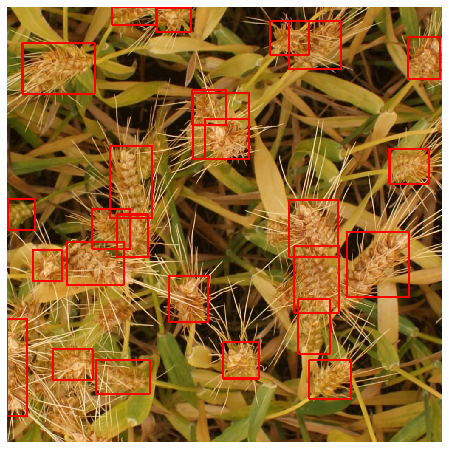

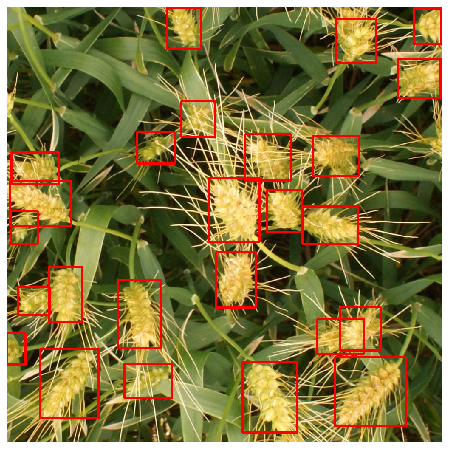

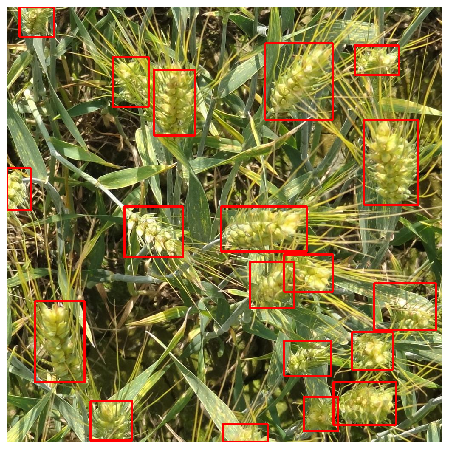

In [24]:
for image_id, pred_str in zip(sub_df.iloc[:3]['image_id'], sub_df.iloc[:3]['PredictionString']):
    image_path = os.path.join(DATA_DIR, 'test', f'{image_id}.jpg')
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    boxes = get_bboxes(pred_str)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2] + box[0], box[3] + box[1]),
                      (255, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)
    plt.show()